<a href="https://colab.research.google.com/github/inesbsilveira/2nd-semester-2023/blob/main/20230911_workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.4 MB/s eta 0:00:00


In [2]:
import rasterio
from rasterio.windows import Window
import os
import shutil
import numpy as np
from PIL import Image

from fastai.vision.all import *
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
user='I' # escolher 'M' ou 'I'
N_epochs=2
target_names = ['not greenhouse', 'greenhouse']
Nrows,Ncols = 20, 8 # número de blocos a usar 20*8=160

In [5]:
# Specify the directory path
if user=='M':
  directory = '/content/drive/MyDrive/inv_proj/S2change_DGT/Estufas_Alentejo'
else:
  directory = '/content/drive/MyDrive/AAA/'

image_folder_name = "images"
label_folder_name = "labels"
predicted_folder_name = "predicted"
image_folder = os.path.join(directory, image_folder_name)
label_folder = os.path.join(directory, label_folder_name)
predicted_folder = os.path.join(directory, predicted_folder_name)

training_set_file_name = "training_set.txt"
test_set_file_name = "test_set.txt"

Rasterio

In [7]:
def clip_raster_to_subrasters(input_file, output_folder, Nrows, Ncols):
    with rasterio.open(input_file) as src:
        height = src.height // Nrows
        width = src.width // Ncols

        for i in range(Nrows):
            for j in range(Ncols):
                ymin = i * height
                ymax = (i + 1) * height
                xmin = j * width
                xmax = (j + 1) * width
                window = Window.from_slices((ymin, ymax), (xmin, xmax))

                clipped_data = src.read(window=window)
                clipped_meta = src.meta.copy()
                clipped_meta.update({
                    'height': window.height,
                    'width': window.width,
                    'transform': src.window_transform(window)
                })

                output_file = os.path.join(output_folder, f'image_{i}_{j}_mask.png')
                with rasterio.open(output_file, 'w', **clipped_meta) as dst:
                    dst.write(clipped_data)


In [8]:
def rescale_to_8bits(arr):
    arr_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    arr_std = arr_std.astype(np.uint8)
    return arr_std

In [9]:
def clip_and_rescale_to_8bits(input_file, output_folder, Nrows, Ncols):
    with rasterio.open(input_file) as src:
        height = src.height // Nrows
        width = src.width // Ncols

        for i in range(Nrows):
            for j in range(Ncols):
                ymin = i * height
                ymax = (i + 1) * height
                xmin = j * width
                xmax = (j + 1) * width
                window = Window.from_slices((ymin, ymax), (xmin, xmax))

                clipped_data_1 = rescale_to_8bits(src.read(1, window=window))
                clipped_data_2 = rescale_to_8bits(src.read(2, window=window))
                clipped_data_3 = rescale_to_8bits(src.read(3, window=window))

                rgb_image = np.stack([clipped_data_1, clipped_data_2, clipped_data_3], axis=2)

                image = Image.fromarray(rgb_image, mode='RGB')
                output_file = os.path.join(output_folder, f'image_{i}_{j}.png')
                image.save(output_file)


In [17]:
# Define the function to extract the row and column number from the test image file name
def get_row_column_from_filename(filename):
    filename = os.path.basename(filename)
    parts = filename.split('_')
    row = int(parts[1])
    column = int(parts[2].split('.')[0])
    return row, column

In [18]:
# Create DataBlock
def get_items(path):
    image_files = get_image_files(image_folder)
    return image_files

def get_mask_fn(image_file):
    return mask_folder / f'{image_file.stem}_mask.png'

In [19]:
# Save predicted mask
def save_predicted_masks(test_dl, learn, output_folder):
    preds = learn.get_preds(dl=test_dl)[0]
    for idx, pred in enumerate(preds):
        sample_image_path = list(test_dl.items)[idx]
        row, column = get_row_column_from_filename(sample_image_path)
        row_folder = os.path.join(output_folder, f'row_{row}')
        os.makedirs(row_folder, exist_ok=True)
        predicted_filename = f'image_{row}_{column}_predicted.png'
        predicted_filepath = os.path.join(row_folder, predicted_filename)
        sample_pred = pred.argmax(dim=0).numpy()
        predicted_image = Image.fromarray((sample_pred * 255).astype(np.uint8))
        predicted_image.save(predicted_filepath)

In [20]:
# Merge the predicted mask
def merge_predicted_masks(input_folder, output_file, Nrows, Ncols):
    height = width = None
    for i in range(Nrows):
        for j in range(Ncols):
            predicted_file = os.path.join(input_folder, f'row_{i}', f'image_{i}_{j}_predicted.png')
            predicted_image = Image.open(predicted_file)
            if height is None:
                width, height = predicted_image.size
            else:
                width, height = max(width, predicted_image.width), max(height, predicted_image.height)

    merged_width = width * Ncols
    merged_height = height * Nrows
    merged_image = Image.new('RGB', (merged_width, merged_height))

    for i in range(Nrows):
        for j in range(Ncols):
            predicted_file = os.path.join(input_folder, f'row_{i}', f'image_{i}_{j}_predicted.png')
            predicted_image = Image.open(predicted_file)
            x_offset = j * width
            y_offset = i * height
            merged_image.paste(predicted_image, (x_offset, y_offset))

    merged_image.save(output_file)

In [21]:
def display_sample_predictions(sample_files, test_dl, learn, image_folder, label_folder, predicted_folder):
    num_columns = 3
    fig, axes = plt.subplots(len(sample_files), num_columns, figsize=(15, 5 * len(sample_files)))

    for i, file_name in enumerate(sample_files):
        sample_image_path = image_folder / file_name
        sample_image = PILImage.create(sample_image_path)
        sample_pred = learn.get_preds(dl=test_dl)[0][i].argmax(dim=0).numpy()
        row, column = get_row_column_from_filename(file_name)
        # Load the truth mask
        true_mask = np.array(Image.open(label_folder / f'image_{row}_{column}_mask.png'))
        # Load the predicted mask for the sample from the "predicted" folder
        predicted_mask = np.array(Image.open(predicted_folder/ f'image_{row}_{column}_predicted.png'))

        axes[i, 0].imshow(sample_image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title(file_name + " True mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(sample_pred, cmap='tab20')
        axes[i, 2].set_title(file_name + " Predicted mask")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

Main Execution

In [10]:
# Clip and rescale label images
clip_raster_to_subrasters(os.path.join(directory, 'mask_3763_reclass.tif'), label_folder, Nrows, Ncols)

# Clip and rescale image bands
clip_and_rescale_to_8bits(os.path.join(directory, '3bands_clipped_tif.tif'), image_folder, Nrows, Ncols)


In [22]:
path=Path(directory)
image_folder = path/'images'
mask_folder = path/'labels'

# Create DataBlock
items = get_items(path)
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(target_names)),
                   get_items=get_items,
                   get_y=get_mask_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

# Create DataLoaders
dls = dblock.dataloaders(path, bs=8)

In [23]:
# Create a stratified split of the indices for training and test set
train_idx, test_idx = RandomSplitter(valid_pct=0.2, seed=42)(items)
train_items = [items[i] for i in train_idx]
test_items = [items[i] for i in test_idx]

# Write the training set items to a txt file
training_set_file = path / 'training_set.txt'
with open(training_set_file, 'w') as f:
    for item in train_items:
        f.write(str(item) + '\n')

# Write the test set items to a txt file
test_set_file = path / 'test_set.txt'
with open(test_set_file, 'w') as f:
    for item in test_items:
        f.write(str(item) + '\n')

print("Paths of training and test sets have been stored in 'training_set.txt' and 'test_set.txt' respectively.")

Paths of training and test sets have been stored in 'training_set.txt' and 'test_set.txt' respectively.


In [25]:
# Define U-Net model
learn = unet_learner(dls, resnet34)

# Train the model
# In the following line of code, adjust the number of epochs to see different results
learn.fine_tune(N_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 120MB/s]


epoch,train_loss,valid_loss,time
0,0.410999,0.223776,00:42


epoch,train_loss,valid_loss,time
0,0.329208,0.245033,00:46
1,0.320927,0.253435,00:44


<Axes: >

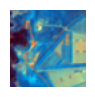

In [27]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder)) # todas as 160 imagens (não é só validação)
preds = learn.get_preds(dl=test_dl)[0]
preds.shape # 160 imagens, 2 classes, 58=nrows do bloco, 57=ncolumns do bloco

# Display sample predictions
sample_idx = 0
sample_image_path = list(test_dl.items)[sample_idx]
sample_image = PILImage.create(sample_image_path)
sample_pred = preds[0][sample_idx].argmax(dim=0).numpy()

sample_image.show()
#TensorImage(sample_pred).show(cmap='tab20')

In [ ]:
# Save predicted masks
save_predicted_masks(test_dl, learn, predicted_folder)
# Merge predicted masks into one image
merge_predicted_masks(input_folder, output_file, Nrows, Ncols)
# Display sample predictions
display_sample_predictions(test_files, test_dl, learn, image_folder, label_folder, predicted_folder)